In [29]:
from datagenerator import *
from metrics import *
from keras.models import load_model
import matplotlib.pyplot as plt

In [30]:
TEST_PATH = 'data/test'

def predict(case_path, model):
    X = np.empty((VOLUME_SLICES, IMG_SIZE, IMG_SIZE, 2))
    flair = nb.load(TEST_PATH+'/'+case_path+'/'+case_path+'_flair.nii.gz').get_fdata()
    t1ce = nb.load(TEST_PATH+'/'+case_path+'/'+case_path+'_t1ce.nii.gz').get_fdata()
    for j in range(VOLUME_SLICES):
        X[j,:,:,0] = cv2.resize(flair[:,:,j+VOLUME_START_AT], (IMG_SIZE,IMG_SIZE))
        X[j,:,:,1] = cv2.resize(t1ce[:,:,j+VOLUME_START_AT], (IMG_SIZE,IMG_SIZE))
    return model.predict(X/np.max(X), verbose=1)

In [31]:
custom_objects = {'specificity': specificity,
                  'sensitivity': sensitivity,
                  'dice_coef': dice_coef,
                  'dice_coef_necrotic': dice_coef_necrotic,
                  'dice_coef_enhancing': dice_coef_enhancing,
                  'dice_coef_edema': dice_coef_edema,
                  'precision': precision}
model = load_model('model/unet_v1.h5', custom_objects=custom_objects, compile=True)

In [32]:
pred = predict('BraTS2021_00030', model)

4/4 [==============================] - 7s 1s/step


In [34]:
orig = nb.load('data/test/BraTS2021_00030/BraTS2021_00030_flair.nii.gz').get_fdata()
ground_truth = nb.load('data/test/BraTS2021_00030/BraTS2021_00030_seg.nii.gz').get_fdata()

In [35]:
SEGMENT_CLASSES = {
    0 : 'NON-TUMOR',
    1 : 'NECROTIC/CORE',
    2 : 'EDEMA',
    3 : 'ENHANCING'
}

In [40]:
def vis(orig, pred, ground_truth, start_slice=60):
    core = pred[:, :, :, 1]
    edema= pred[:, :, :, 2]
    enhancing = pred[:, :, :, 3]
    plt.figure(figsize=(18, 50))
    f, axarr = plt.subplots(1,6, figsize = (18, 50))
    for i in range(6):
        axarr[i].imshow(cv2.resize(orig[:,:,start_slice+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE)), cmap="gray", interpolation='none')
    axarr[0].imshow(cv2.resize(orig[:, :, start_slice+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE)), cmap='gray')
    axarr[0].title.set_text('Original image flair')
    gt = cv2.resize(ground_truth[:, :, start_slice+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE), interpolation = cv2.INTER_NEAREST)
    axarr[1].imshow(gt, cmap='Reds', interpolation='none', alpha=0.3)
    axarr[1].title.set_text('Ground truth')
    axarr[2].imshow(pred[start_slice, :, :, 1:4], cmap='Reds', interpolation='none', alpha=0.3)
    axarr[2].title.set_text('All classes')
    axarr[3].imshow(edema[start_slice, :, :], cmap='OrRd', interpolation='none', alpha=0.3)
    axarr[3].title.set_text(f'{SEGMENT_CLASSES[1]} Predicted')
    axarr[4].imshow(core[start_slice, :], cmap='OrRd', interpolation='none', alpha=0.3)
    axarr[4].title.set_text(f'{SEGMENT_CLASSES[2]} Predicted')
    axarr[5].imshow(enhancing[start_slice, :], cmap='OrRd', interpolation='none', alpha=0.3)
    axarr[5].title.set_text(f'{SEGMENT_CLASSES[3]} Predicted')
    plt.show()

<Figure size 1800x5000 with 0 Axes>

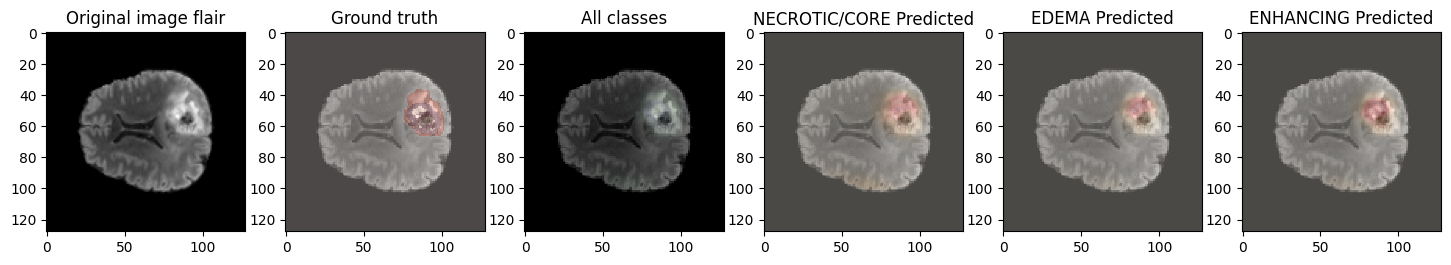

In [41]:
vis(orig, pred, ground_truth)